# 14.1 Отбор признаков

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

ds = fetch_california_housing()
X, y = ds.data, ds.target

indexes = np.arange(len(y))
np.random.seed(52342)
np.random.shuffle(indexes)

X = X[indexes, :]
y = y[indexes]

Отбор по корреляции

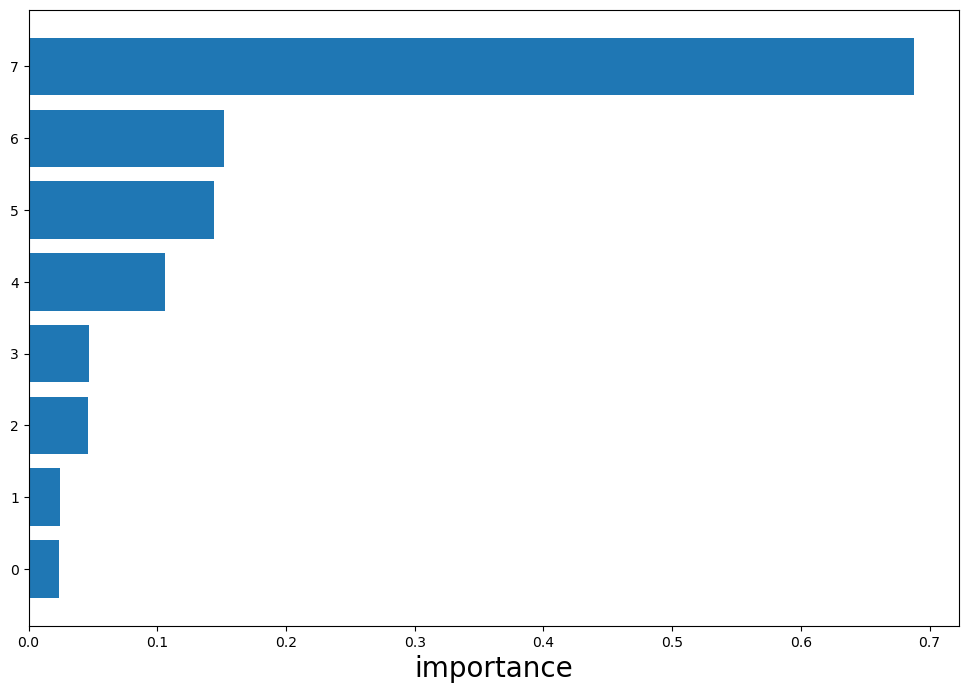

In [3]:
features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)

fig = plt.figure(figsize=(12,8))
plt.barh(features_ind, corrs[importances_sort])
plt.xlabel('importance', fontsize=20)
X = X[:, importances_sort]

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

features_counts = np.arange(X.shape[1])

def scores_by_cnt(reg):
    scores = []
    for features_part in tqdm(features_counts):
        X_part = X[:,importances_sort[features_part:]]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


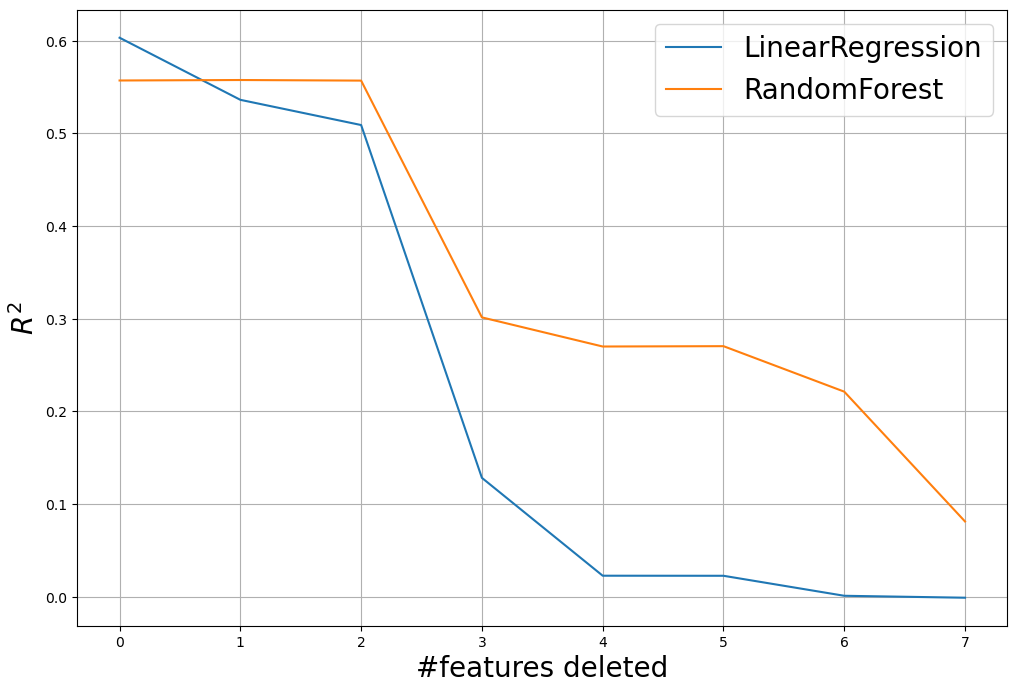

In [5]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Отбор по взаимной информации

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

select = SelectKBest(score_func=mutual_info_regression, k='all')
z = select.fit_transform(X, y)

importances_sort = np.argsort(select.scores_)

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


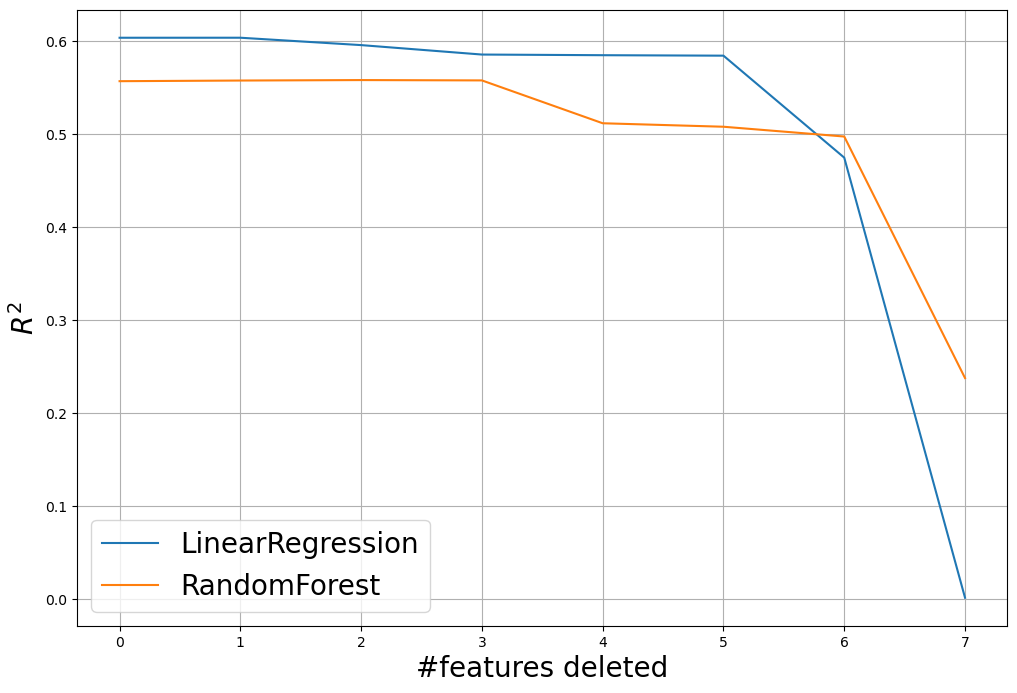

In [7]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Рекурсивный отбор

In [8]:
from sklearn.feature_selection import RFE

def scores_by_rfe(reg):
    scores = []
    for num_features in tqdm(np.arange(8,0,-1)):
        estimator = LinearRegression()
        selector = RFE(estimator, n_features_to_select=num_features, step=1)
        selector = selector.fit(X, y)

        X_part = selector.transform(X)
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores

linreg_scores = scores_by_rfe(LinearRegression())
rf_scores = scores_by_rfe(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


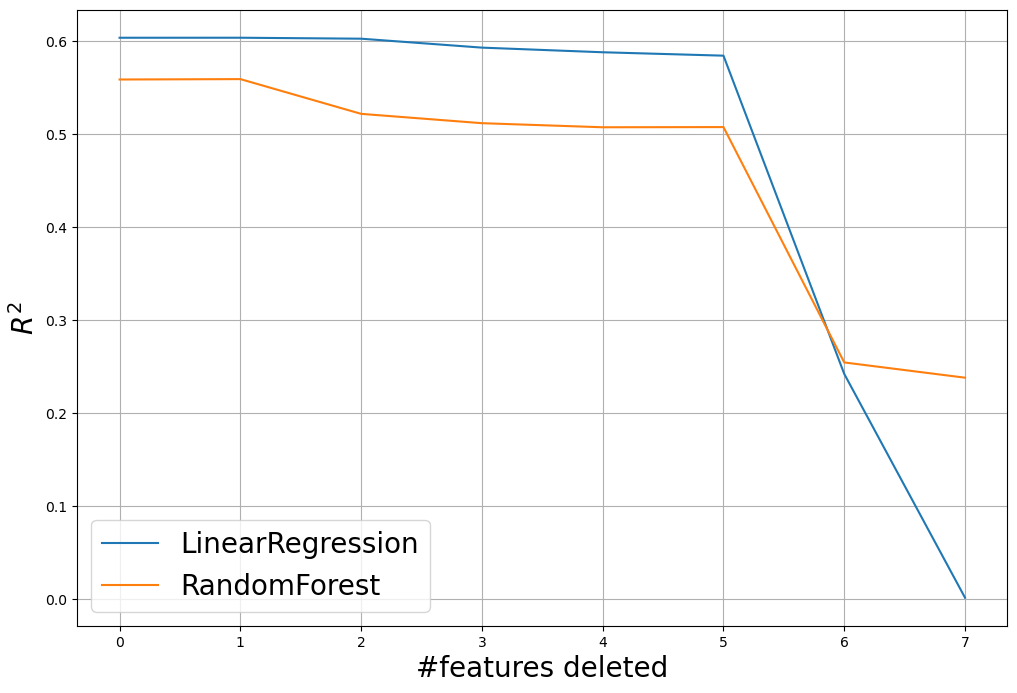

In [9]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

Отбор по модели

In [10]:
from sklearn.feature_selection import SelectFromModel

estimator = LinearRegression()
selector = SelectFromModel(estimator)
selector = selector.fit(X, y)

importances_sort = np.argsort(selector.estimator_.coef_)

linreg_scores = scores_by_cnt(LinearRegression())
rf_scores = scores_by_cnt(RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1))

100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


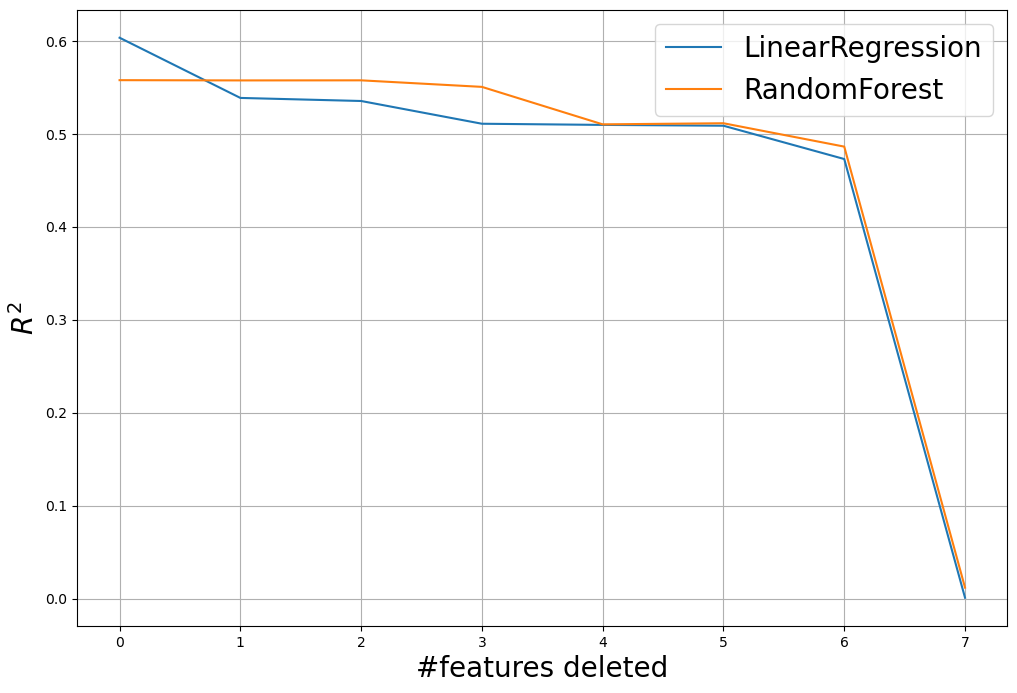

In [11]:
plt.figure(figsize=(12,8))

plt.plot(features_counts, linreg_scores, label='LinearRegression')
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best', fontsize=20)
plt.xlabel('#features deleted', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.grid()

# 14.2 Метод главных компонент (Principal Components Analysis, PCA)

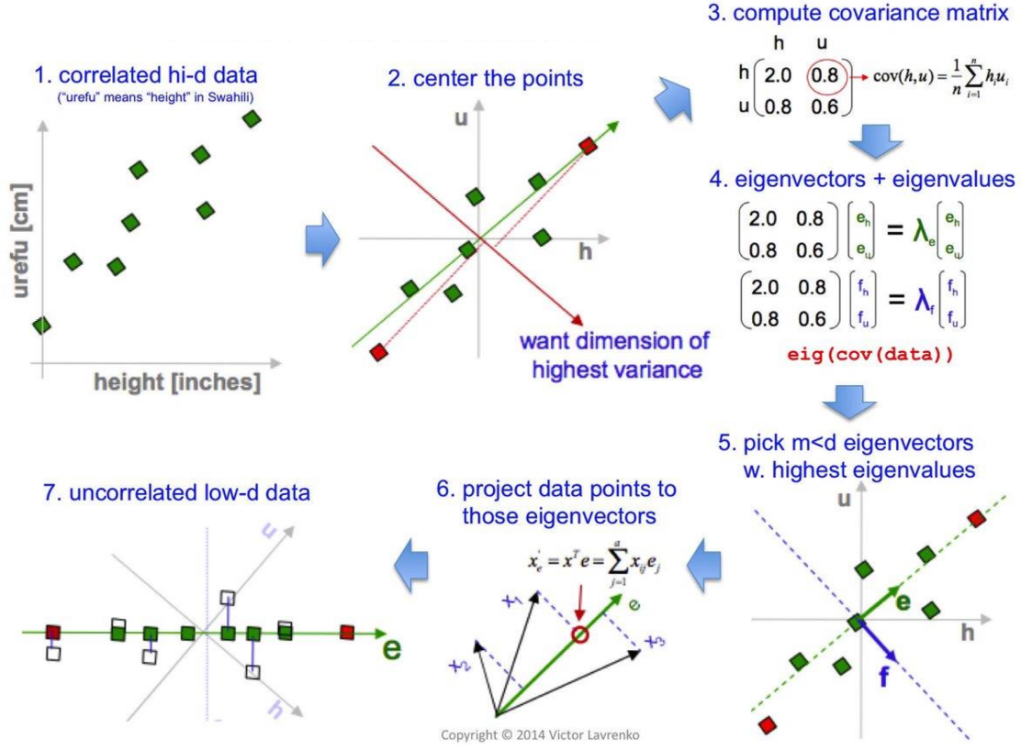

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RANDOM_STATE = 42

Загружаем данные

In [13]:
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data,
                  columns=diabetes.feature_names)

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


Применяем PCA

Внутри метода данные уже центрированы

In [14]:
pca = PCA(n_components=10)

pca.fit_transform(df)

array([[ 0.02793021, -0.09260136,  0.02802565, ..., -0.03602731,
        -0.00861288, -0.00232845],
       [-0.13468668,  0.06526327,  0.00132849, ...,  0.008963  ,
         0.02402649,  0.00207377],
       [ 0.01294384, -0.07776432,  0.03516224, ..., -0.04010708,
        -0.00120593, -0.00257685],
       ...,
       [-0.00976067, -0.05733918,  0.02360117, ...,  0.02339486,
        -0.00538535,  0.00280039],
       [ 0.03295652,  0.00999473, -0.04132099, ..., -0.0037426 ,
        -0.00605083, -0.00216612],
       [-0.09056122,  0.18910841, -0.0022992 , ..., -0.0563818 ,
         0.03474513, -0.00735156]])

Вычисляем долю объясненной дисперсии

In [15]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

In [16]:
prop_var

array([0.40242108, 0.14923197, 0.12059663, 0.09554764, 0.06621814,
       0.06027171, 0.05365657, 0.0433682 , 0.007832  , 0.00085607])

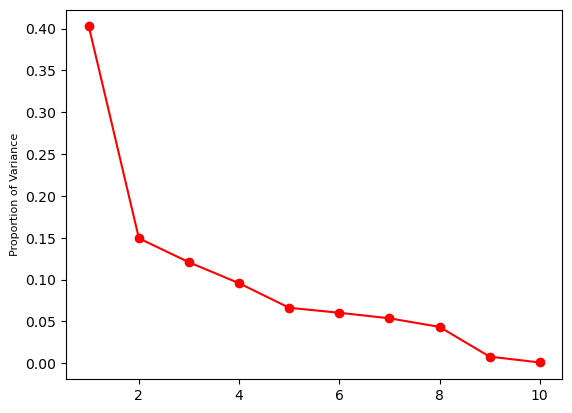

In [17]:
PC_numbers = np.arange(pca.n_components_) + 1

plt.plot(PC_numbers,
         prop_var,
         'ro-')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

PCA для дальнейших задач

In [18]:
from sklearn.model_selection import train_test_split

X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

pca = PCA(n_components=5)
pca.fit(X_train)

X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [19]:
X_train.shape, X_train_reduced.shape

((331, 10), (331, 5))

# 14.4 Визуализация данных при помощи t-SNE

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.manifold import TSNE

RANDOM_STATE = 42

Загрузим данные

In [21]:
from sklearn.datasets import load_digits

digits = load_digits()

pixel_data = digits.data
target = digits.target

pixel_data.shape

(1797, 64)

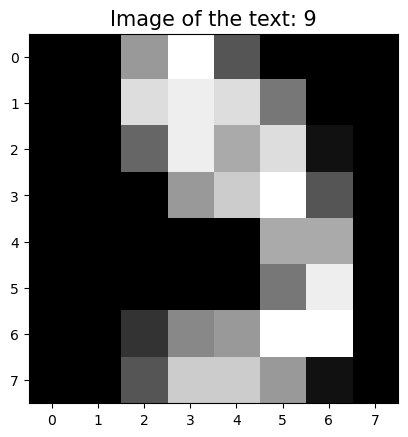

In [22]:
single_image = pixel_data[105, :].reshape(8,8)

plt.imshow(single_image, cmap='gray')
plt.title(f"Image of the text: {target[105]}", fontsize=15)
plt.show()

Будем делать визуализацию на плоскости (n_components = 2)

In [23]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)

x_transformed = tsne.fit_transform(pixel_data)

In [24]:
tsne_df = pd.DataFrame(np.column_stack((x_transformed, target)), columns=['X', 'Y', "Targets"])

tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)

In [25]:
tsne_df.head(10)

,X,Y,Targets
0,-3.335068,-56.418331,0.0
1,10.269802,12.005585,1.0
2,-13.776518,18.993013,2.0
3,-35.093025,-6.141835,3.0
4,41.463013,7.720223,4.0
5,-26.671852,-14.797441,5.0
6,33.246620,-14.147943,6.0
7,2.484659,41.202866,7.0
8,-14.255411,6.074697,8.0
9,-19.623457,-14.731346,9.0


Нарисуем результат

<Figure size 1000x800 with 0 Axes>

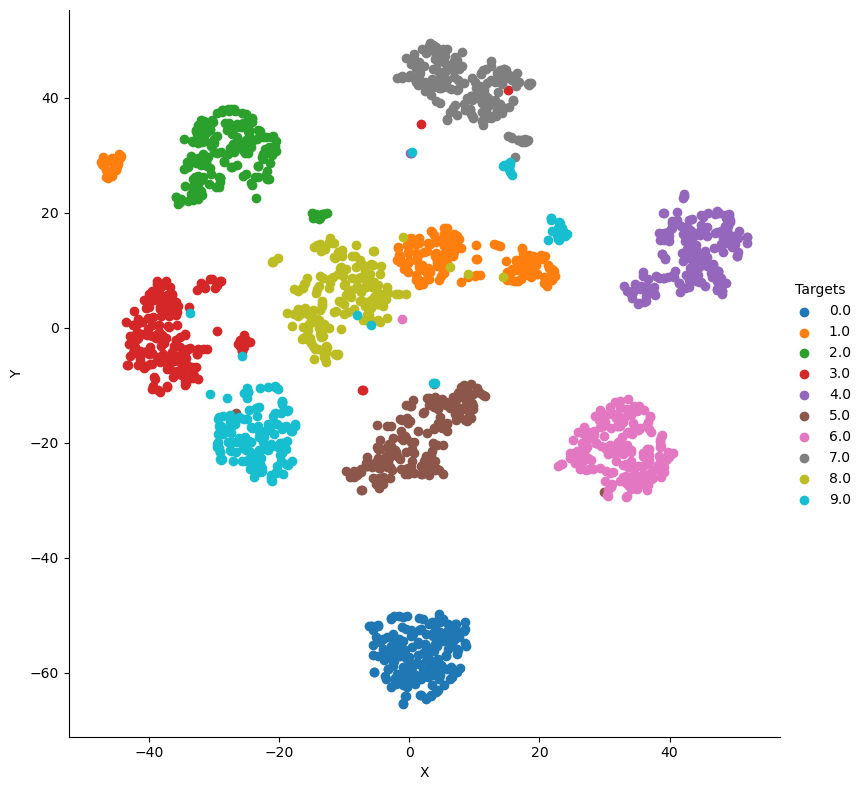

In [26]:
plt.figure(figsize=(10,8))

g = sns.FacetGrid(data=tsne_df, hue='Targets', height=8)

g.map(plt.scatter, 'X', 'Y').add_legend()

plt.show()

# Сжатие изображения без потери качества при помощи PCA

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 # conda install conda-forge::opencv

from scipy.stats import stats
from sklearn.decomposition import PCA

Загрузим картинку и нарисуем ее в монохромный формат

In [28]:
%%capture
!wget -O flower.png "https://www.dropbox.com/s/xoos0myk285efyu/flower.png?dl=0"

In [29]:
img = cv2.cvtColor(cv2.imread('flower.png'), cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

error: OpenCV(4.10.0) C:\b\abs_e4cxka7_7g\croot\opencv-suite_1738943368733\work\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


## Вопрос для Quiz

Какого размера картинка img? В ответе запишите общее число пикселей.

In [ ]:
# ваш код здесь

Посмотрим на матрицу изображения

In [ ]:
img

array([[16, 16, 16, ..., 10, 10, 10],
       [16, 16, 16, ..., 10, 10, 10],
       [16, 16, 16, ..., 10, 10, 10],
       ...,
       [19, 19, 19, ..., 10, 10, 10],
       [19, 19, 19, ..., 10, 10, 10],
       [19, 19, 19, ..., 10, 10, 10]], dtype=uint8)

### Сейчас будем делать PCA

**Задание.** Масштабируйте данные, поделив значения в матрице на 255

In [ ]:
# Ваш код здесь

**Задание.** Обучите PCA с 50-ю компонентами. Снизьте размерность.

In [ ]:
# Ваш код здесь

## Вопрос для Quiz

Выведите на экран долю дисперсии, объясняемой первыми 50-ю главными компонентами. Ответ округлите до сотых.

In [ ]:
# Ваш код здесь

**Задание.** Нарисуйте график, на котором отобразите долю дисперсии, объясняемой каждой из первых 50-ти компонент.

In [ ]:
# Ваш код здесь

### Восстанавливаем изображение

**Задание.** Восстановите изображение, используя pca.inverse_transform.

In [ ]:
# Ваш код здесь

**Задание.** Нарисуйте рядом два изображения: исходное и восстановленное (по своим 50 компонентам).

In [ ]:
# Ваш код здесь

## Вопрос для Quiz

Упало ли визуально качество при сжатии изображения до 50 главных компонент?

## Вопрос для Quiz

Подберите минимальное количество компонент, при которых сжатое изображение визуально практически не отличается от исходного. Подбор происходит перебором, ориентируемся на визуальный результат.

In [ ]:
# Ваш код здесь

## Бонус

Попробуйте проделать все действия ноутбука, но уже с цветным изображением.

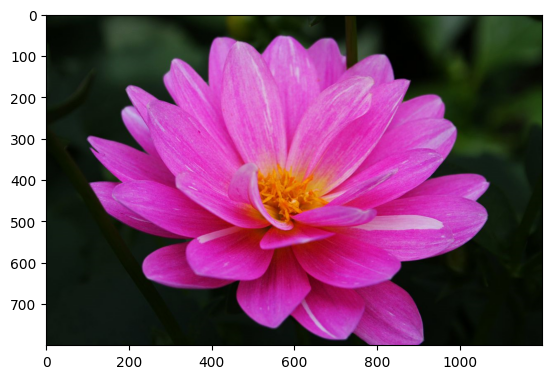

In [ ]:
img = cv2.cvtColor(cv2.imread('flower.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Отличия от предыдущих шагов заключаются в том, что цветное RGB-изображение состоит из трех каналов - это матрица яркостей красного, матрица яркостей зеленого и матрица яркостей синего цветов.

Номер канала - последняя размерность в объекте `img`.
Например, матрица яркости красного - это `img[:,:,0]`.

Все действия выше нужно проделать с каждым каналом в отдельности, а потом объединить преобразованные изображения для каждого канала - чтобы получить итоговую картинку со сниженной размерностью.

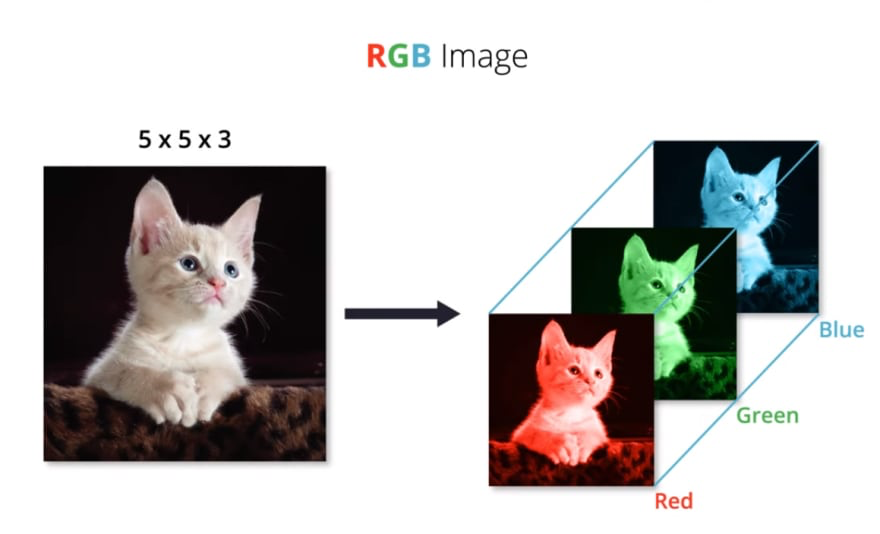

In [ ]:
# ваш код здесь

## Вопрос для Quiz

Найдите любое цветное изображение, которое вам нравится и снизьте его размерность, подберите минимальное число компонент, чтобы визуально не терять качество.

Вы можете снижать размерность для монохромного или для цветного изображения.

Результат - исходное изображение + его размеры, а также изображение после снижения размерности + число компонент.

In [ ]:
# ваш код здесь